# Classification. Linear models and KNN

Files in '/Users/smoluakov/Documents/Code/rs_school/week_5': ['.DS_Store', 'test.csv', 'hw_classification.ipynb', 'train.csv', '.ipynb_checkpoints']


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

self.weights_ = np.zeros(num_featuresGradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

In [36]:
X_train.shape

(1437, 64)

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [211]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your>
        
        # DONE
         
        return 1.0 / (1.0 + np.exp(-weights @ X.T))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        # maybe fix np.exp(-(x @ weights) * y
        #w_x = np.sum((weights@x) @ w_0)
        if x.shape[1] == weights.shape[0]:
            loss = np.sum((np.log(1.0 + np.exp(-(x @ weights) * y))) / len(y)) + ((1.0 / (2.0 * self.C)) * np.amin(np.linalg.norm(weights,2)))
        else:
            ones = np.ones((x.shape[0],1))
            X = np.column_stack((ones,x))
            loss = np.sum((np.log(1.0 + np.exp(-(X @ weights) * y))) / len(y)) + ((1.0 / (2.0 * self.C)) * np.amin(np.linalg.norm(weights,2)))
    
        return loss
    
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        loss_history = []
        
        for i in range(self.max_iter):
            delta = np.zeros(num_features)
            #delta = -(((np.multiply(X_ext.T, y)) @ (1.0 - (1.0 / (1.0 + np.exp(np.multiply((np.dot(X_ext,self.weights_.T)),y)))))) / len(y)) + (self.weights_ / self.C)
            for j in range(X_ext.shape[0]):
                delta += ((X_ext[j] * y[j]) * (1.0 - (1.0 / (1.0 + np.exp(-(self.weights_ @ X_ext[j])*y[j])))) / len(y))
            delta = (self.weights_ / self.C) - delta
            
            #delta = -((X_ext.T @ y * (1.0 - (1.0 / (1.0 + np.exp(-(self.weights_ @ X_ext.T) * y))))) / len(y)) + (self.weights_ / self.C)
          
            loss_history.append(self.get_loss(X_ext,self.weights_, y))
            self.weights_ -= self.eta * delta
            #print(np.linalg.norm(delta*self.eta))
            if np.linalg.norm(delta) < self.tol:
                break
        return loss_history
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        a= []
        if hasattr(self, 'weights_'):
            a=self.predict_proba(X)
            a[a >= 0.5] = 1
            return np.where(a >= 0.5, a, -1)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
        # <your code>
        

In [212]:
from sklearn import datasets
from sklearn import metrics

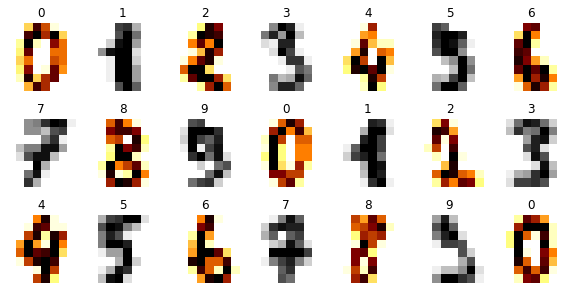

In [213]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [214]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [216]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [46]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [47]:
lr_clf.fit(X_train, y_train)

[0.6931471805599454]

In [48]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [49]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [50]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [23]:
model = CustomLogisticRegression()

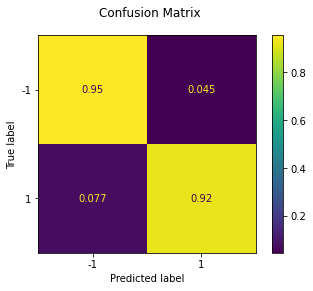

In [24]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [25]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [26]:
assert min(train_acc, test_acc) > 0.9

In [30]:
(model_2.weights_).shape

(65,)

**(0.5 points)** Visualize the loss history.

In [51]:
model_2 = CustomLogisticRegression()

In [53]:
model_2.fit(X_train, y_train);

In [54]:
## your 



y_pred_2= model_2.predict(X_train)
model_2.get_loss(X_train, model_2.weights_, y_train)

0.38902331201688245

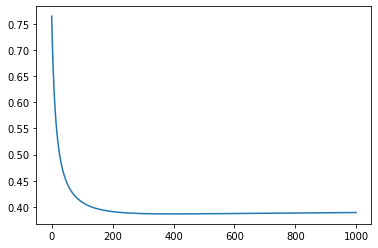

In [55]:
plt.plot(range(len(model_2.fit(X_train, y_train))), model_2.fit(X_train, y_train))

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

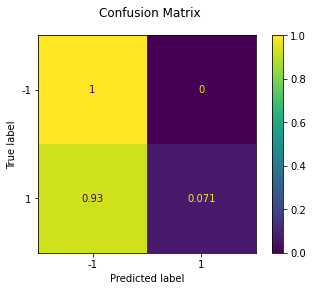

0.5455810716771051 0.5277777777777778


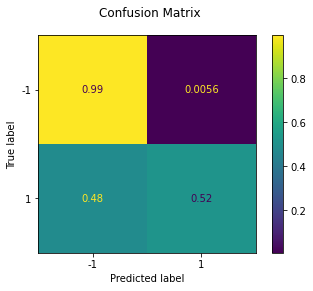

0.7731384829505915 0.7527777777777778


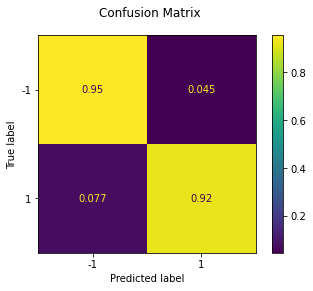

0.9109255393180237 0.9388888888888889


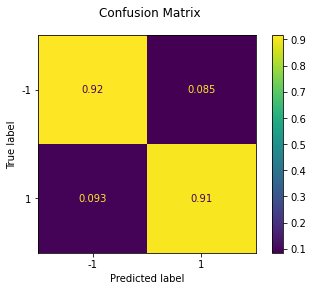

0.8844815588030619 0.9111111111111111


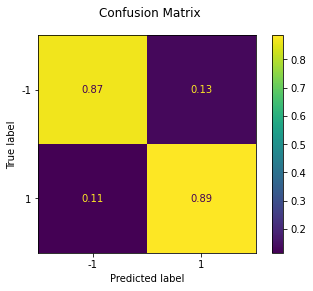

0.848990953375087 0.8777777777777778


In [220]:
## your code

model_3_4= CustomLogisticRegression(eta=0.1)
train_acc_3_4, test_acc_3_4 = fit_evaluate(model_3_4, X_train, y_train, X_test, y_test);
print(train_acc_3_4, test_acc_3_4)


model_3 = CustomLogisticRegression(eta=0.01)
train_acc_3, test_acc_3 = fit_evaluate(model_3, X_train, y_train, X_test, y_test);
print(train_acc_3, test_acc_3)

model_3_3= CustomLogisticRegression(eta=0.001)
train_acc_3_3, test_acc_3_3 = fit_evaluate(model_3_3, X_train, y_train, X_test, y_test);
print(train_acc_3_3, test_acc_3_3)

model_3_2= CustomLogisticRegression(eta=0.0001)
train_acc_3_2, test_acc_3_2 = fit_evaluate(model_3_2, X_train, y_train, X_test, y_test);
print(train_acc_3_2, test_acc_3_2)


model_3_5= CustomLogisticRegression(eta=0.00001)
train_acc_3_5, test_acc_3_5 = fit_evaluate(model_3_5, X_train, y_train, X_test, y_test);
print(train_acc_3_5, test_acc_3_5)

### Результаты растут с ростом learning rate, но при достижении оптимального значения роста уже не происходит. Происходит наоборот снижение точности, как на трейне, так и на тесте. 

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [70]:
Cs = np.arange(0.1, 1, 0.1,)


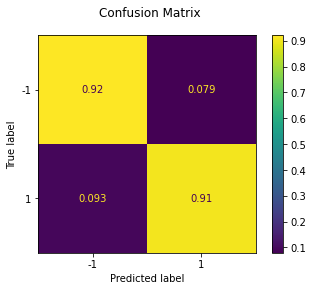

0.8879610299234516 0.9138888888888889


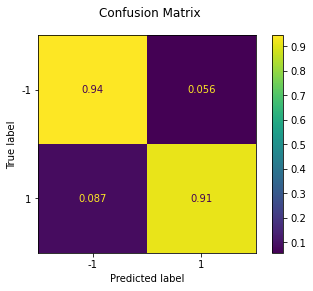

0.9039665970772442 0.9277777777777778


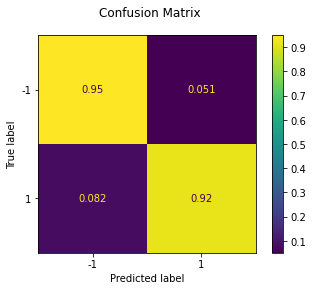

0.9102296450939458 0.9333333333333333


"\n\ndef plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, \n                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):\n    plt.figure(figsize=(9, 4.5))\n    plt.plot(x, metric_train, label='Training')\n    plt.plot(x, metric_valid, color='C1', label='Validation')\n    #plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)\n    plt.title(title)\n    plt.xlabel(xlabel)\n    plt.ylabel(ylabel)\n    plt.grid(True)\n    plt.xticks(x, rotation='vertical')\n    plt.legend(loc='center left')        \n    if custom_metric:\n        plt.twinx()\n        plt.yscale(custom_scale)\n        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) \n        plt.legend(loc='center right')         \n    plt.show()\n\ntrain_acc, test_acc = [], []\nfor c in Cs:\n    mod = CustomLogisticRegression(C=c).fit(X_train, y_train)\n    train_acc.append(metrics.accuracy_score(y_pred=mod.predict(X_trai

In [72]:

model_4 = CustomLogisticRegression(C=0.1)
train_acc_4, test_acc_4 = fit_evaluate(model_4, X_train, y_train, X_test, y_test)
print(train_acc_4, test_acc_4)

model_5 = CustomLogisticRegression(C=0.5)
train_acc_5, test_acc_5 = fit_evaluate(model_5, X_train, y_train, X_test, y_test)
print(train_acc_5, test_acc_5)


model_6 = CustomLogisticRegression(C=0.8)
train_acc_6, test_acc_6 = fit_evaluate(model_6, X_train, y_train, X_test, y_test)
print(train_acc_6, test_acc_6)

'''

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    #plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()

train_acc, test_acc = [], []
for c in Cs:
    mod = CustomLogisticRegression(C=c).fit(X_train, y_train)
    train_acc.append(metrics.accuracy_score(y_pred=mod.predict(X_train), y_true=y_train))
    test_acc.append(y_pred=mod.predict(X_test), y_true=y_test)
    
plot_fitting_graph(Cs, train_acc, test_acc, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')
'''

### **Можно заметить, что с ростом регяризации точность модели возрастает.**

**(0.5 points)** Compare zero initialization and random initialization. 

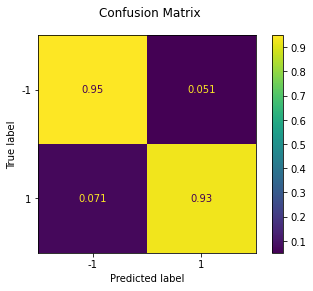

0.9116214335421016 0.9388888888888889


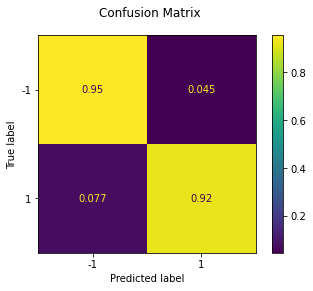

0.9109255393180237 0.9388888888888889


In [74]:
## your code
model_7 = CustomLogisticRegression(zero_init=True)
train_acc_7, test_acc_7 = fit_evaluate(model_7, X_train, y_train, X_test, y_test);
print(train_acc_7, test_acc_7)

model_8 = CustomLogisticRegression(zero_init=False)
train_acc_8, test_acc_8 = fit_evaluate(model_8, X_train, y_train, X_test, y_test);
print(train_acc_8, test_acc_8)

качество на тесте у обоих моделей одинаковое. На обучающей выборке различия также почти не наблюдаются.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:


$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [221]:
from scipy.spatial import distance
point_1 = X[1]
point_2 = X[2]
euclidean_distance = distance.euclidean(point_1, point_2)
euclidean_distance

41.6293165929973

In [224]:
distances = -2 * X_train@X_test.T + np.sum(X_test**2,axis=1) + np.sum(X_train**2,axis=1)[:, np.newaxis]
distances[distances < 0] = 0
distances = distances**.5

In [225]:
distances
indices = np.argsort(distances, 0) #get indices of sorted items
distances = np.sort(distances,0) #distances sorted in axis 0

In [226]:
indices

array([[ 713,  382, 1076, ...,  956, 1093,  783],
       [ 428,  861,  947, ...,  897,  615,   81],
       [ 805,  802, 1033, ...,  951,  742,  101],
       ...,
       [ 953, 1251, 1353, ..., 1228, 1278,  146],
       [ 294,  845,  971, ..., 1145, 1325, 1079],
       [1289,  593,  872, ...,  837,   89,  593]])

In [133]:
distances

array([[14.49137675, 16.40121947, 12.20655562, ..., 26.57066051,
        23.51595203, 13.15294644],
       [16.73320053, 21.9317122 , 15.16575089, ..., 27.05549852,
        24.18677324, 17.8325545 ],
       [17.11724277, 22.89104628, 16.64331698, ..., 27.80287755,
        24.63736999, 18.65475811],
       ...,
       [65.24568951, 62.05642594, 63.71812929, ..., 61.00819617,
        66.6183158 , 62.41794614],
       [65.68104749, 62.41794614, 64.29618962, ..., 61.76568627,
        67.05221846, 62.84106937],
       [66.44546636, 62.8251542 , 64.37390776, ..., 63.30876717,
        70.46275612, 64.91532947]])

In [227]:
matrix = np.empty(X_train.shape[0]*X_test.shape[0]).reshape(X_train.shape[0],X_test.shape[0])

In [228]:
matrix.shape
for i in range(X_train.shape[0]):
    for j in range(X_test.shape[0]):
        matrix[i][j] = np.sqrt(np.sum((X_train[i] - X_test[j])**2))

In [233]:
maxValue = np.amax(matrix)

In [234]:
maxValue

75.34586916347837

In [229]:
print(matrix.shape)

(1437, 360)


In [230]:
np.argsort(matrix, 0)

array([[ 713,  382, 1076, ...,  956, 1093,  783],
       [ 428,  861,  947, ...,  897,  615,   81],
       [ 805,  802, 1033, ...,  951,  742,  101],
       ...,
       [ 953, 1251, 1353, ..., 1228, 1278,  146],
       [ 294,  845,  971, ..., 1145, 1325, 1079],
       [1289,  593,  872, ...,  837,   89,  593]])

In [236]:
(np.sort(matrix,0)[:10]).shape

(10, 360)

In [156]:
weights_of_points = 1 / (matrix + 1e-9)

In [161]:
weights_of_points

array([[0.02496103, 0.01837416, 0.01915653, ..., 0.01951428, 0.01892189,
        0.0203658 ],
       [0.02056725, 0.02555715, 0.02256468, ..., 0.02253602, 0.02305102,
        0.02699746],
       [0.02180104, 0.02459595, 0.0180246 , ..., 0.02196344, 0.02037848,
        0.02262235],
       ...,
       [0.0180422 , 0.02014149, 0.02206479, ..., 0.02829559, 0.02148675,
        0.01992048],
       [0.01977969, 0.02500782, 0.01944775, ..., 0.02897638, 0.01795474,
        0.02048939],
       [0.02501564, 0.01801582, 0.02029437, ..., 0.02090148, 0.01913197,
        0.01804807]])

In [163]:
classes = np.unique(y)

In [183]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [245]:
smallest_distances = matrix.argsort()[:10]
smallest_distances
weights_of_points = 1 / (smallest_distances)

/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/1543824363.py:3: RuntimeWarning: divide by zero encountered in true_divide
  weights_of_points = 1 / (smallest_distances)


In [256]:
weights_of_points.flatten().shape

(3600,)

In [ ]:
smallest_distances = P.argsort()[:self.n_neighbors]
                

In [ ]:
get_class_weights()

после сортировки вы должны получить матрицу, в которой строки - это объекты, для которых вы делаете пресдказания, а значения в столбцах - расстояние от каждого этого объекта до каждого объекта из обучающей выборки
и значения в столбцах должны быть отсортированы после сортировки
потому что для каждого объекта мы ищем его ближайши соседей
для него потом получить обратные веса

In [257]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        matrix = np.empty(X.shape[0]*Y.shape[0]).reshape(X.shape[0],Y.shape[0])
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                matrix[i][j] = np.sqrt(np.sum((X[i] - Y[j])**2))
        return matrix
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        n = dict(zip(self.classes_, np.zeros(len(self.classes_))))
        for i,j in enumerate(y):
            if j in n.keys():
                n[j] += weights[i]
                
        return list(n.values())
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                for 
                smallest_distances = P.argsort()[:self.n_neighbors]
                weights_of_points = 1 / (smallest_distances + self.eps)
                
            res = []
            res.append(self.get_class_weights(self.y,weights_of_points.flatten()))
        
            return np.array(res)
            #return # matrix 360x10
                
            #return self.get_class_weights(self.y, weights_of_points)
            
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """

        # <your code>
        return predictions

In [258]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [259]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [260]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

In [261]:
model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4]))

[2.0, 4.0, 0.0]

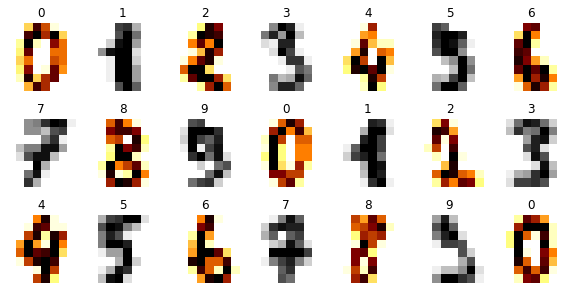

In [262]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [263]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [264]:
a = model.predict_proba(X_test)

In [268]:
a

array([[1.00000000e+09, 4.63508267e-01, 6.49527450e-01, 6.34642940e-01,
        9.17261246e-01, 4.22198776e-01, 9.29319945e-01, 1.59438652e+00,
        7.38527103e-01, 4.86135300e-01]])

In [270]:
knn.predict_proba(X_test)[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [188]:
knn.predict(X_test)

array(['6', '9', '3', '7', '2', '1', '5', '2', '5', '2', '1', '9', '4',
       '0', '4', '2', '3', '7', '8', '8', '4', '3', '9', '7', '5', '6',
       '3', '5', '6', '3', '4', '9', '1', '4', '4', '6', '9', '4', '7',
       '6', '6', '9', '1', '3', '6', '1', '3', '0', '6', '5', '5', '1',
       '9', '5', '6', '0', '9', '0', '0', '1', '0', '4', '5', '2', '4',
       '5', '7', '0', '7', '5', '9', '9', '5', '4', '7', '0', '4', '5',
       '5', '9', '9', '0', '2', '3', '8', '0', '6', '4', '4', '9', '1',
       '2', '8', '3', '5', '2', '9', '0', '4', '4', '4', '3', '5', '3',
       '1', '3', '5', '9', '4', '2', '7', '7', '4', '4', '1', '9', '2',
       '7', '8', '7', '2', '6', '9', '4', '0', '7', '2', '7', '5', '8',
       '7', '5', '7', '9', '0', '6', '6', '4', '2', '8', '0', '9', '4',
       '6', '9', '9', '6', '9', '0', '3', '5', '6', '6', '0', '6', '4',
       '3', '9', '3', '4', '7', '2', '9', '0', '4', '5', '3', '6', '5',
       '9', '9', '8', '4', '2', '1', '3', '7', '7', '2', '2', '3

In [94]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

ValueError: operands could not be broadcast together with shapes (10,1437) (360,10) 

In [153]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [360, 1437]

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [66]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import cross_val_score

In [ ]:
PATH = "./data/"

In [206]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/Users/smoluakov/Documents/Code/ml-intro-2022/5_classification_linear_knn': ['README.md', 'examples.ipynb', '.ipynb_checkpoints']


In [137]:
data = pd.read_csv("train.csv")

In [138]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [139]:
data.shape

(100000, 12)

In [140]:
data.drop(labels=["PassengerId"], axis=1, inplace=True)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [141]:
numeric_features = ["Age", "SibSp", "Parch", "Fare"]
categoric_features = ["Survived", "Pclass", "Sex", "Embarked"]

In [142]:
data.isna().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age          3292
SibSp           0
Parch           0
Ticket       4623
Fare          134
Cabin       67866
Embarked      250
dtype: int64

In [143]:
data.dropna(subset=["Age", "Fare", "Embarked"], inplace=True)

In [144]:
data.shape

(96332, 11)

In [145]:
data.isna().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket       4452
Fare            0
Cabin       65371
Embarked        0
dtype: int64

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

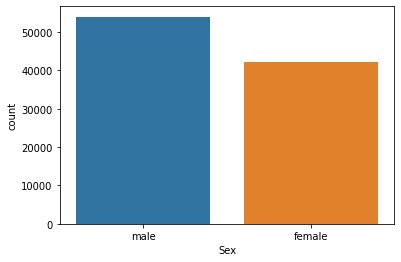

In [146]:
## your code
#data["Survived"].value_counts()
data["Sex"].value_counts()
sns.countplot(x=data["Sex"]);

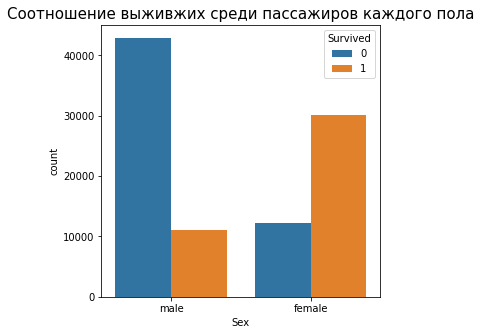

In [147]:
fig = plt.figure(figsize=(5, 5))
sns.countplot(x="Sex", hue="Survived", data=data);

plt.title("Соотношение выживжих среди пассажиров каждого пола", {"fontsize": 15});

Среди выживших больше женщин,чем мужчин

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [148]:
data["Age"].describe()

count    96332.000000
mean        38.352635
std         18.314608
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

In [149]:
data["Fare"].describe()

count    96332.000000
mean        43.923143
std         69.523747
min          0.680000
25%         10.030000
50%         24.480000
75%         33.520000
max        744.660000
Name: Fare, dtype: float64

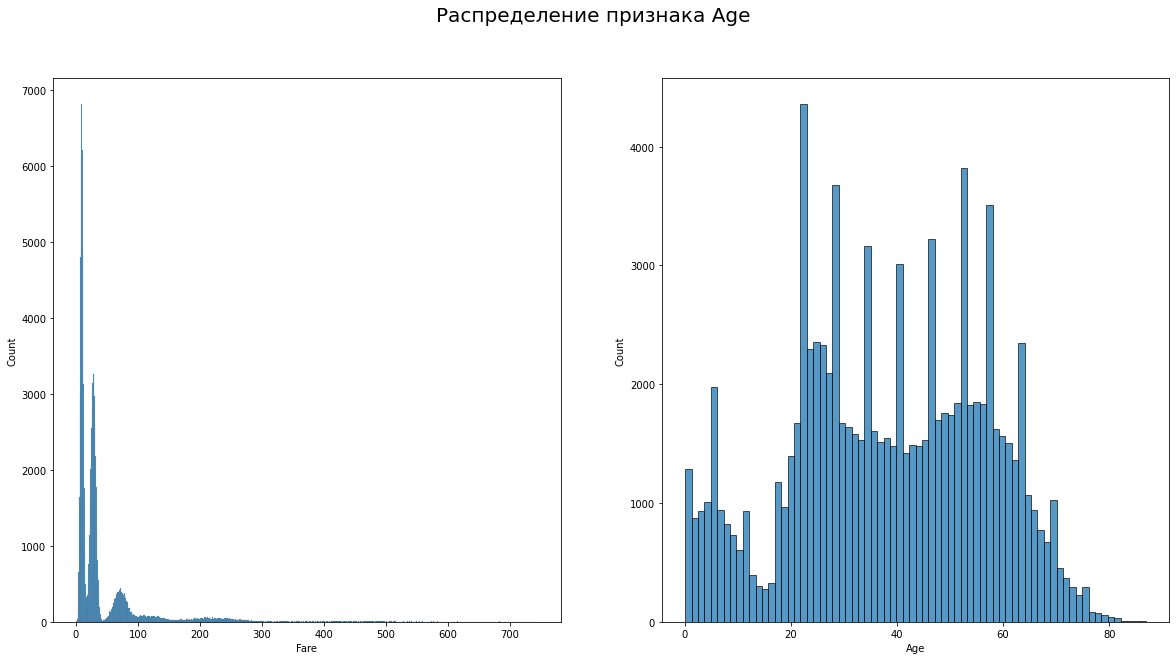

In [150]:
## your code

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Распределение признака Fare', fontsize=20)
sns.histplot(ax=axes[0], data=data, x="Fare");
fig.suptitle('Распределение признака Age', fontsize=20)
sns.histplot(ax=axes[1],data=data, x="Age");



< your thoughts >

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

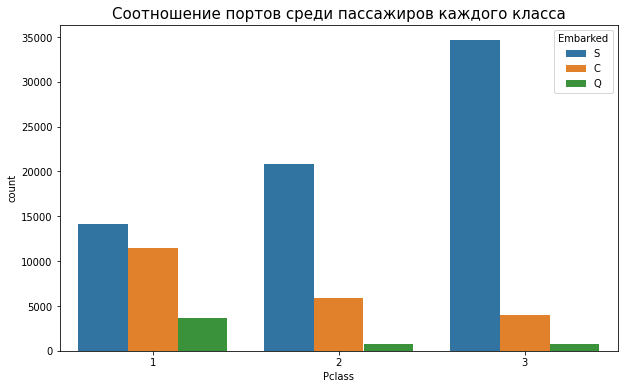

In [36]:
fig = plt.figure(figsize=(10, 6))
sns.countplot(x="Pclass", hue="Embarked", data=data);
plt.title("Соотношение портов среди пассажиров каждого класса", {"fontsize": 15});


среди пассажиров первого и второго класса выживших больше, чем среди пассажиров третьего класса.
Видим, что пассажиры третьего класса грузились преимущественно в порту Southampton

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [151]:
## your code]

data = data.drop('Name', axis=1,)
data = data.drop('Ticket', axis=1,)
data = data.drop('Fare', axis=1,)
data = data.drop('Cabin', axis=1,)
data['Family'] = data['SibSp'] + data['Parch'] + 1
data = data.drop('SibSp', axis=1,)
data = data.drop('Parch', axis=1,)

In [153]:
data.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
Embarked    0
Family      0
dtype: int64

In [154]:
feat_list = list(data.columns.values)

for feat in feat_list:
    print (feat,": ",sum(pd.isnull(data[feat])))

Survived :  0
Pclass :  0
Sex :  0
Age :  0
Embarked :  0
Family :  0


In [155]:
data["Adult"] = 0


In [156]:
data["Adult"][data["Age"] >= 18] = 1

/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/1880217826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Adult"][data["Age"] >= 18] = 1


In [157]:
data_1 = data.filter(['Pclass','Sex','Embarked','Family','Adult'], axis=1)
X = data_1

In [158]:
data_2 = data['Survived']
y = data_2

In [159]:
X["Sex"][data["Sex"] == "male"] = 1
X["Sex"][data["Sex"] == "female"] = 2


/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/693212158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Sex"][data["Sex"] == "male"] = 1
/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/693212158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Sex"][data["Sex"] == "female"] = 2


In [160]:
X["Embarked"][data["Embarked"] == "S"] = 1
X["Embarked"][data["Embarked"] == "C"] = 2
X["Embarked"][data["Embarked"] == "Q"] = 3

/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/1081915095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Embarked"][data["Embarked"] == "S"] = 1
/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/1081915095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Embarked"][data["Embarked"] == "C"] = 2
/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/1081915095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [92]:
X = X.drop('Embarked', axis=1,)
X = X.drop('Family', axis=1,)

In [161]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42)

In [162]:
X_train.shape

(67432, 5)

In [171]:
X

,Pclass,Sex,Embarked,Family,Adult
2,3,1,1,4,0
3,3,1,1,1,1
4,3,1,1,1,1
5,2,1,1,1,1
6,3,1,1,1,0
...,...,...,...,...,...
99995,2,2,2,1,1
99996,2,1,1,1,1
99997,3,1,1,1,1
99998,3,1,1,2,1


In [172]:
X_test.shape

(28900, 5)

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [173]:
knn=KNeighborsClassifier()
#logReg=LogisticRegression(solver='liblinear')
knn.fit(X_train,y_train)
prediction_knn=knn.predict(X_test)
#pred_train=logReg.predict(train_y)
score=cross_val_score(knn,X_train,y_train,cv=5)
print("Score:",score)
#print("Confusion_matrix:",confusion_matrix(train_y,pred_train))
acc_log_knn = round(knn.score(X_train,y_train) * 100, 2)
acc_log_knn

Score: [0.75798917 0.72810855 0.76145633 0.7403233  0.74744179]


74.51

In [174]:
logReg=LogisticRegression(solver='liblinear')
logReg.fit(X_train,y_train)
prediction=logReg.predict(X_test)
#pred_train=logReg.predict(train_y)
score=cross_val_score(logReg,X_train,y_train,cv=5)
print("Score:",score)
#print("Confusion_matrix:",confusion_matrix(train_y,pred_train))
acc_log = round(logReg.score(X_train,y_train) * 100, 2)
acc_log

Score: [0.75546823 0.75880477 0.76041821 0.75700727 0.75797123]


75.8

In [175]:
test=pd.read_csv('test.csv')

In [176]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [177]:
test_set = test[['Pclass', 'Sex', 'Age','Embarked','SibSp','Parch']].copy()

In [178]:
test_set['Family'] = test_set['SibSp'] + test_set['Parch'] + 1

In [179]:
test_set = test_set.drop('SibSp', axis=1,)
test_set = test_set.drop('Parch', axis=1,)

In [180]:
test_set.columns.values

array(['Pclass', 'Sex', 'Age', 'Embarked', 'Family'], dtype=object)

In [189]:

test_list = list(test_set.columns.values)

for test_item in test_list:
    print (test_item,": ",sum(pd.isnull(test_set[test_item])))

Pclass :  0
Sex :  0
Embarked :  277
Family :  0
Adult :  0


In [182]:
test_set["Age"] = test_set["Age"].fillna(test_set["Age"].median())

In [183]:
test_set["Adult"] = 0
test_set["Adult"][test_set["Age"] >= 18] = 1

### Dropping the Age column

test_set = test_set.drop('Age', axis=1,)

/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/4037679501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["Adult"][test_set["Age"] >= 18] = 1


In [184]:
test_set["Sex"][test_set["Sex"] == "male"] = 1
test_set["Sex"][test_set["Sex"] == "female"] = 2

/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/1460882575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["Sex"][test_set["Sex"] == "male"] = 1
/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/1460882575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["Sex"][test_set["Sex"] == "female"] = 2


In [186]:
test_set["Embarked"][test_set["Embarked"] == "S"] = 1
test_set["Embarked"][test_set["Embarked"] == "C"] = 2
test_set["Embarked"][test_set["Embarked"] == "Q"] = 3

/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/1154109922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["Embarked"][test_set["Embarked"] == "S"] = 1
/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/1154109922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["Embarked"][test_set["Embarked"] == "C"] = 2
/var/folders/ky/0pprcqtj4n74fc7bjg8w_ct00000gn/T/ipykernel_85178/1154109922.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [190]:
test_set["Embarked"] = test_set["Embarked"].fillna(test_set["Embarked"].median())

In [196]:
test_set.head()

,Pclass,Sex,Embarked,Family,Adult
0,3,1,1.0,1,1
1,3,2,1.0,1,1
2,1,2,2.0,1,1
3,2,1,1.0,1,1
4,1,2,2.0,3,0


In [197]:
final_pred = logReg.predict(test_set)

In [127]:
test['Survived'] = pd.Series(final_pred, index=test.index)

ValueError: Length of passed values is 100000, index implies 1.

In [122]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S,NaN
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S,NaN
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C,NaN
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S,NaN
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C,NaN


In [128]:
final_df = test.filter(['PassengerId','Survived'], axis=1)

In [125]:
final_df.reset_index()

,index,PassengerId,Survived
0,0,100000,NaN
1,1,100001,NaN
2,2,100002,NaN
3,3,100003,NaN
4,4,100004,NaN
...,...,...,...
99995,99995,199995,NaN
99996,99996,199996,NaN
99997,99997,199997,NaN
99998,99998,199998,NaN


In [116]:
final_df.to_csv("titanic_pred.csv", encoding='utf-8')

In [129]:
final_df.shape

(100000, 2)

In [ ]:
prediction_test=logReg.predict(X_test)

In [198]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": final_pred
    })

In [199]:
submission

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1


In [200]:
submission.to_csv('submission.csv',index=False)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

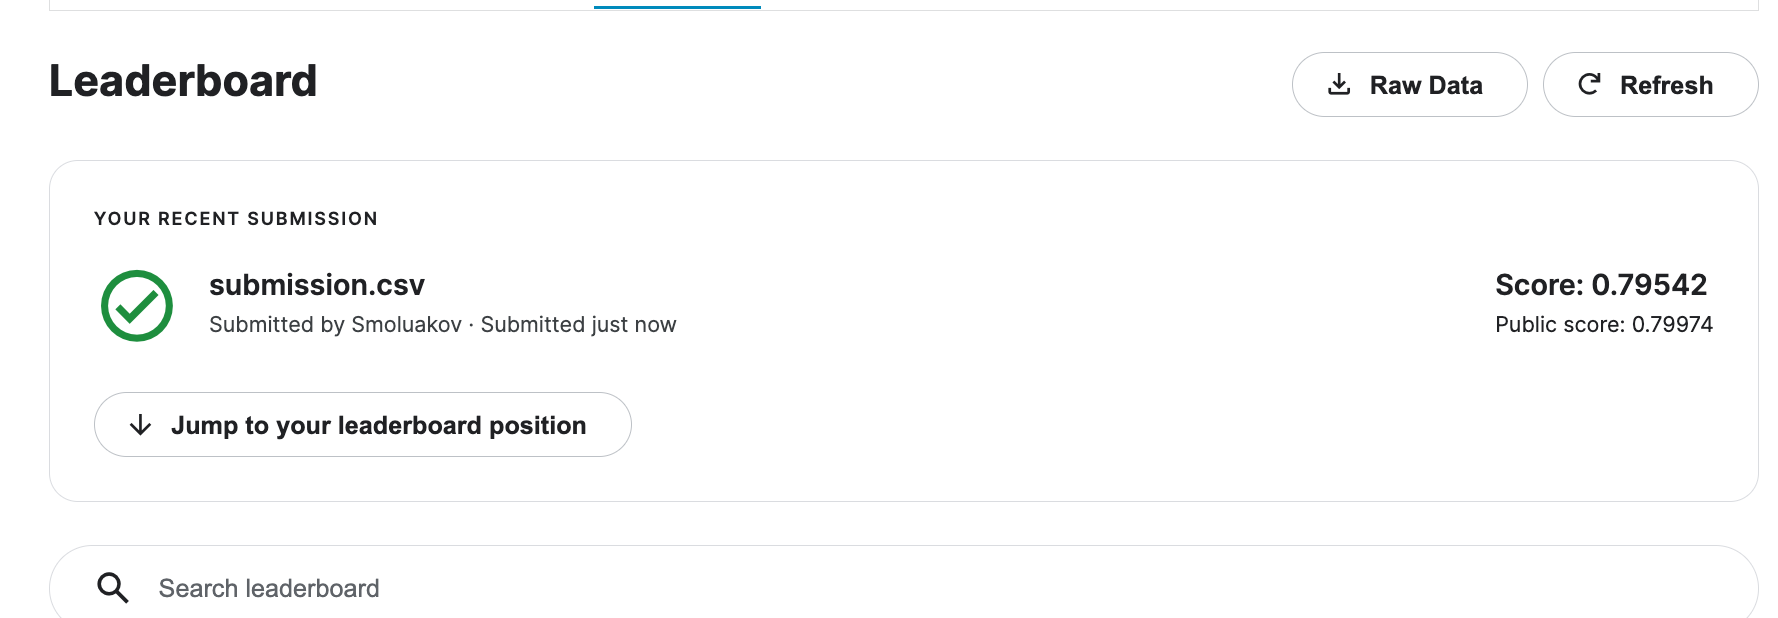

In [209]:
from IPython.display import Image
Image("sub.png")